<a href="https://colab.research.google.com/github/DikshaMeena03/AI-Powered-Adaptive-Traffic-Control-System/blob/main/AI_Powered_Traffic_Control_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AI-Powered Adaptive Traffic Control System

|--NOTE: to run the code please access datasets on your Google drive: https://drive.google.com/drive/folders/1bSCc0mKUd0Oar8DqIwjucPvdVKMw2vI-?usp=drive_link
____________________________________________________________________________
This project introduces an AI-Powered Adaptive Traffic Control System designed to alleviate urban congestion. Leveraging a multi-faceted approach, the system integrates Deep Reinforcement Learning (DRL) for optimal signal timing, YOLO algorithms for real-time vehicle detection, and LSTM networks for predictive traffic flow analysis.
____________________________________________________________________________
**1. AI-Powered Adaptive Traffic Control System**: Dynamic, intelligent system for real-time traffic signal optimization.

**2. Deep Reinforcement Learning (DRL):** Optimizes signal timing through learned strategies to reduce congestion.
YOLO (You Only Look Once): Enables real-time, accurate vehicle detection from camera feeds.

**3. LSTM Networks:** Predicts traffic flow to allow for proactive signal adjustments.
Data-Driven Approach: Utilizes real-time data from IoT sensors and camera feeds.

**4. Advanced ML Models:** Processes raw data for insights and decision-making.
Dynamic Signal Adjustment: Minimizes congestion and waiting times by adapting signal timings.

**5. SUMO Simulator with TraCI API:** Provides a virtual environment for development, testing, and validation.

**6. Comprehensive Scenario Modeling:** Ensures robustness and effectiveness across varied traffic conditions.

**7. Multi-Layered Architecture:** Modular design for data collection, computer vision, AI decisions, and control.

**8. Software-Based Solution:** No physical infrastructure changes required, enabling cost-effective deployment.
________________________________________________________________________________

## 0. System Architecture & Methodology
### 0.1 Overall System Architecture

Diagram below illustrates the complete architecture of the AI-powered adaptive traffic control system.
It shows the flow of traffic data from the simulation environment through the decision-making modules and finally to the adaptive signal controller.

[System Architecture](https://drive.google.com/file/d/15E6uxXIXVbHKwsResrLLu6dl5BIdHAr4/view?usp=drive_link)
### 0.2 Reinforcement Learning Interaction Diagram

This diagram represents the interaction between the reinforcement learning agent
and the traffic environment in terms of state, action, reward, and environment response.

[RL Interaction Diagram](https://drive.google.com/file/d/1DhDD2y1NrE8NwHaSUhq8xgxJm19pHz04/view?usp=drive_link)



## 1. Setting Environment for Project
#### 1.1 Connect to the SUMO environment

In [ ]:
import os

os.environ["SUMO_HOME"] = "/usr/share/sumo"
print("SUMO_HOME set to:", os.environ["SUMO_HOME"])


SUMO_HOME set to: /usr/share/sumo


#### 1.2 Mount Google Drive & Create Project Folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change this path if you want a different folder name/location
project_root = '/content/drive/MyDrive/smart_traffic'

import os
os.makedirs(os.path.join(project_root, 'sumo'), exist_ok=True)
os.makedirs(os.path.join(project_root, 'ml'), exist_ok=True)

print("Project root:", project_root)


Mounted at /content/drive
Project root: /content/drive/MyDrive/smart_traffic


## 2. Installation of Dependencies (SUMO + Python libs)

In [ ]:
!apt-get -y install sumo sumo-tools > /dev/null

!pip install numpy pandas matplotlib scikit-learn tensorflow \
             stable-baselines3 gymnasium joblib > /dev/null

print("Installed SUMO and Python libraries.")


Installed SUMO and Python libraries.


##3. Create SUMO Network & Config (in Colab)
We’ll use a simple 4-way grid intersection and generate traffic flows.

-b(start time)

-e(end time)

perior(new trip per sec / traffic desity)
#### 3.1 Generate the network

In [ ]:
%%bash
# 1) Set project root
project_root="/content/drive/MyDrive/smart_traffic"

# 2) Make sure sumo folder exists
mkdir -p "$project_root/sumo"
cd "$project_root/sumo"

# 3) Tell SUMO where it is installed (removes SUMO_HOME warning)
export SUMO_HOME=/usr/share/sumo

echo "SUMO_HOME is $SUMO_HOME"

# 4) Generate a 2x2 grid network where all junctions are traffic lights
netgenerate \
  --grid \
  --grid.x-number=2 --grid.y-number=2 \
  --grid.length=300 \
  --default-junction-type traffic_light \
  -o net.net.xml

echo "Generated net.net.xml in $PWD"

# 5) Generate a valid routes file using randomTrips.py
python $SUMO_HOME/tools/randomTrips.py \
  -n net.net.xml \
  -r routes.rou.xml \
  -b 0 -e 3600 \
  --period 2

echo "Generated routes.rou.xml in $PWD"

# 6) Show files
ls


SUMO_HOME is /usr/share/sumo
Success.
Generated net.net.xml in /content/drive/MyDrive/smart_traffic/sumo
calling /usr/share/sumo/bin/duarouter -n net.net.xml -r trips.trips.xml --ignore-errors --begin 0 --end 3600 --no-step-log --no-warnings -o routes.rou.xml
Success.
Generated routes.rou.xml in /content/drive/MyDrive/smart_traffic/sumo
generate_data.py
net.net.xml
routes.rou.alt.xml
routes.rou.xml
traffic_data.csv
traffic.sumocfg
trips.trips.xml


bash: line 19:  1381 Segmentation fault      (core dumped) netgenerate --grid --grid.x-number=2 --grid.y-number=2 --grid.length=300 --default-junction-type traffic_light -o net.net.xml


#### 3.2 Create route file

In [ ]:
%%writefile /content/drive/MyDrive/smart_traffic/sumo/routes.rou.xml
<?xml version="1.0" encoding="UTF-8"?>
<routes>
    <vType id="car" accel="1.0" decel="4.5" sigma="0.5" length="5" maxSpeed="16.67"/>
    # advancement 5
    <vType id="emergency" accel="2.0" decel="4.5" maxSpeed="25" color="1,0,0"/>

    <!-- Simple flows from each side to the opposite side -->
    <flow id="flow_n2s" type="car" begin="0" end="3600" vehsPerHour="600" from="1/0" to="1/1"/>
    <flow id="flow_s2n" type="car" begin="0" end="3600" vehsPerHour="600" from="1/1" to="1/0"/>
    <flow id="flow_w2e" type="car" begin="0" end="3600" vehsPerHour="600" from="0/0" to="2/0"/>
    <flow id="flow_e2w" type="car" begin="0" end="3600" vehsPerHour="600" from="2/0" to="0/0"/>
    <flow id="emergency_flow"
      type="emergency"
      begin="600" end="1200"
      vehsPerHour="30"
      from="1/0" to="1/1"/>
</routes>


Overwriting /content/drive/MyDrive/smart_traffic/sumo/routes.rou.xml


#### 3.3. Create SUMO config

In [ ]:
%%writefile /content/drive/MyDrive/smart_traffic/sumo/traffic.sumocfg
<?xml version="1.0" encoding="UTF-8"?>
<configuration>
    <input>
        <net-file value="net.net.xml"/>
        <route-files value="routes.rou.xml"/>
    </input>
    <time>
        <begin value="0"/>
        <end value="3600"/>
        <step-length value="1.0"/>
    </time>
</configuration>


Overwriting /content/drive/MyDrive/smart_traffic/sumo/traffic.sumocfg


## Data Generation with SUMO (in Colab)
We’ll run SUMO headless (no GUI) and log aggregate stats (no lane IDs needed).
#### 4.1. Create generate_data.py

In [ ]:
%%writefile /content/drive/MyDrive/smart_traffic/sumo/generate_data.py
import os
import sys
import csv

# Ensure SUMO tools are on PYTHONPATH
if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = "/usr/share/sumo"

tools = os.path.join(os.environ["SUMO_HOME"], "tools")
sys.path.append(tools)

from sumolib import checkBinary
import traci


def run_sim_and_log(output_csv="traffic_data.csv", max_steps=3600, log_interval=5):
    sumo_binary = checkBinary("sumo")  # headless (no GUI)

    sumo_cmd = [
        sumo_binary,
        "-c", "traffic.sumocfg",
        "--no-step-log", "true",
        "--time-to-teleport", "-1"
    ]

    traci.start(sumo_cmd)
    print("SUMO started.")

    step = 0

    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "total_count", "mean_speed", "queue_length"])

        def get_net_stats():
            lane_ids = traci.lane.getIDList()
            total_count = 0
            total_speed = 0.0
            queue_len = 0

            for lane_id in lane_ids:
                veh_ids = traci.lane.getLastStepVehicleIDs(lane_id)
                total_count += len(veh_ids)
                for vid in veh_ids:
                    v = traci.vehicle.getSpeed(vid)
                    total_speed += v
                    if v < 0.1:
                        queue_len += 1

            mean_speed = total_speed / total_count if total_count > 0 else 0.0
            return total_count, mean_speed, queue_len
        # SIMULATION LOOP #
        while step < max_steps:
            traci.simulationStep()

            if step % log_interval == 0:
                total_count, mean_speed, queue_len = get_net_stats()
                writer.writerow([step, total_count, mean_speed, queue_len])

            step += 1

    traci.close()
    print(f"Simulation finished. Data saved to {output_csv}")


if __name__ == "__main__":
    run_sim_and_log(
        output_csv="traffic_data.csv",
        max_steps=3600,
        log_interval=5
    )


Overwriting /content/drive/MyDrive/smart_traffic/sumo/generate_data.py


In [ ]:
%%bash
export SUMO_HOME=/usr/share/sumo
cd /content/drive/MyDrive/smart_traffic/sumo

# overwrite routes.rou.xml with random, valid routes for this net
python $SUMO_HOME/tools/randomTrips.py \
    -n net.net.xml \
    -r routes.rou.xml \
    -b 0 -e 3600 -p 1.0

echo "Generated routes.rou.xml with randomTrips"
ls


calling /usr/share/sumo/bin/duarouter -n net.net.xml -r trips.trips.xml --ignore-errors --begin 0 --end 3600 --no-step-log --no-warnings -o routes.rou.xml
Success.
Generated routes.rou.xml with randomTrips
generate_data.py
net.net.xml
routes.rou.alt.xml
routes.rou.xml
traffic_data.csv
traffic.sumocfg
trips.trips.xml


#### 4.2 Run data generation

In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/sumo
python generate_data.py
ls

 Retrying in 1 seconds
SUMO started.
Simulation finished. Data saved to traffic_data.csv
generate_data.py
net.net.xml
routes.rou.alt.xml
routes.rou.xml
traffic_data.csv
traffic.sumocfg
trips.trips.xml


## 5. LSTM Model for Traffic Prediction (in Colab)
We’ll use the CSV we just created to train an LSTM that predicts future total vehicle count.

#### 5.1. Create train_lstm.py

In [ ]:
%%writefile /content/drive/MyDrive/smart_traffic/ml/train_lstm.py
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os

# Paths
project_root = "/content/drive/MyDrive/smart_traffic"
data_path = os.path.join(project_root, "sumo", "traffic_data.csv")

# 1. Load data
df = pd.read_csv(data_path)

# --- ADVANCEMENT 2: Noise injection for sim-to-real robustness ---
noise_std = 0.05 * df["queue_length"].std()
df["queue_length"] += np.random.normal(0, noise_std, size=len(df))
df["queue_length"] = df["queue_length"].clip(lower=0)
# -----------------------------------------------------------------

# Features: total_count, queue_length ; Target: future total_count
# --- EXTENSION: Spatio-temporal proxy feature ---
df["queue_ma"] = df["queue_length"].rolling(window=3).mean().fillna(0)

feature_cols = ["total_count", "queue_length", "queue_ma"]
features = df[feature_cols].values

targets = df["total_count"].values.reshape(-1, 1)

# 2. Scale
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_x.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# 3. Create sequences
sequence_length = 10  # use 10 timesteps history

X_sequences = []
y_sequences = []

for i in range(len(features_scaled) - sequence_length):
    X_sequences.append(features_scaled[i:i + sequence_length])
    y_sequences.append(targets_scaled[i + sequence_length])  # next step total count

X = np.array(X_sequences)
y = np.array(y_sequences)

print("X shape:", X.shape)
print("y shape:", y.shape)

# 4. Train/test split (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 5. Build LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, X.shape[2])))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# 6. Train
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# 7. Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# 8. Save model & scalers
model.save(os.path.join(project_root, "ml", "lstm_traffic.keras"))
joblib.dump(scaler_x, os.path.join(project_root, "ml", "scaler_x.pkl"))
joblib.dump(scaler_y, os.path.join(project_root, "ml", "scaler_y.pkl"))

print("Model and scalers saved.")


Overwriting /content/drive/MyDrive/smart_traffic/ml/train_lstm.py


#### 5.2. Run LSTM training

In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/ml
python train_lstm.py


X shape: (710, 10, 3)
y shape: (710, 1)
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4731 - mae: 0.6361 - val_loss: 0.0322 - val_mae: 0.1619
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312 - mae: 0.1511 - val_loss: 0.0115 - val_mae: 0.0927
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - mae: 0.0869 - val_loss: 0.0084 - val_mae: 0.0732
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0604 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - mae: 0.0512 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - mae: 0.0519 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0041 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0487
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0500 - val_loss: 0.0038 - val_mae: 0.0480
Epoch 9/50
15/15 ━━━━━━━

2026-01-10 17:06:45.553400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:06:45.560311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:06:45.583144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768064805.623250    1710 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768064805.635879    1710 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768064805.675356    1710 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 6. DRL (DQN) + SUMO in Colab :
Now we build a Gym environment around SUMO and train a DQN agent.



#### 6.1. Create `sumo_env.py` We’ll use aggregate queue length (no lane IDs, no Netedit needed).

In [ ]:
%%bash
cat > /content/drive/MyDrive/smart_traffic/ml/sumo_env.py << 'EOF'
import os
import sys
import numpy as np
import gymnasium as gym
from gymnasium import spaces

# --- SUMO setup ---
if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = "/usr/share/sumo"

tools = os.path.join(os.environ["SUMO_HOME"], "tools")
sys.path.append(tools)

from sumolib import checkBinary
import traci


class SumoTrafficEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self,
                 config_file="/content/drive/MyDrive/smart_traffic/sumo/traffic.sumocfg",
                 max_steps=3600):
        super().__init__()

        self.config_file = config_file
        self.max_steps = max_steps
        self.current_step = 0

        self.sumo_binary = checkBinary("sumo")
        self.tls_id = None
        self.num_phases = 1

        # Observation: [total_queue, phase_index, neighbor_queue]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0], dtype=np.float32),
            high=np.array([100, 10, 100], dtype=np.float32),
            dtype=np.float32
        )

        # Action: keep phase / switch phase
        self.action_space = spaces.Discrete(2)

        # Metrics
        self.waiting_times = [] # Stores average waiting time per step
        self.queue_lengths = [] # Stores total queue length per step
        self.vehicles_completed = set() # Stores unique IDs of arrived vehicles
        self.peak_queue_length = 0 # Stores the maximum queue length observed during simulation
        self.idle_time = 0 # Not currently used for calculation of metrics for df_results
        self.total_green_time = 0 # Not currently used for calculation of metrics for df_results
        self.last_switch = 0 # Used for reward, not overall metrics.

    def _start_sumo(self):
        traci.start([
            self.sumo_binary,
            "-c", self.config_file,
            "--no-step-log", "true",
            "--time-to-teleport", "-1"
        ])

        self.tls_id = traci.trafficlight.getIDList()[0]
        programs = traci.trafficlight.getAllProgramLogics(self.tls_id)
        self.num_phases = len(programs[0].phases) if programs else 1

    def _get_observation(self):
        total_queue = 0
        for lane in traci.lane.getIDList():
            for vid in traci.lane.getLastStepVehicleIDs(lane):
                if traci.vehicle.getSpeed(vid) < 0.1:
                    total_queue += 1

        phase_index = traci.trafficlight.getPhase(self.tls_id)
        neighbor_queue = total_queue * 0.5  # proxy

        return np.array(
            [total_queue, phase_index, neighbor_queue],
            dtype=np.float32
        )

    def _compute_reward(self, obs):
        total_queue = obs[0]
        avg_wait = self.waiting_times[-1] if self.waiting_times else 0.0

        try:
            co2 = traci.simulation.getCO2Emission()
        except Exception:
            co2 = 0.0

        reward = (
            -0.6 * total_queue
            -0.3 * avg_wait
            -0.1 * (co2 / 1000.0)
            -0.1 * self.last_switch
        )
        return float(reward)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        try:
            traci.close(False)
        except Exception:
            pass

        self.current_step = 0
        self.waiting_times.clear()
        self.queue_lengths.clear()
        self.vehicles_completed.clear()
        self.peak_queue_length = 0 # Reset peak queue length
        self.idle_time = 0
        self.total_green_time = 0
        self.last_switch = 0

        self._start_sumo()
        return self._get_observation(), {}

    def step(self, action):
        if action == 1 and self.num_phases > 1:
            next_phase = (traci.trafficlight.getPhase(self.tls_id) + 1) % self.num_phases
            traci.trafficlight.setPhase(self.tls_id, next_phase)
            self.last_switch += 1
        else:
            self.last_switch = 0

        for _ in range(5):
            traci.simulationStep()
            self.current_step += 1

        veh_ids = traci.vehicle.getIDList()
        # Calculate average waiting time for current step
        avg_wait_this_step = sum(traci.vehicle.getWaitingTime(v) for v in veh_ids) / len(veh_ids) if veh_ids else 0.0
        self.waiting_times.append(avg_wait_this_step)

        # Calculate current queue length
        queue_len_this_step = sum(1 for v in veh_ids if traci.vehicle.getSpeed(v) < 0.1)
        self.queue_lengths.append(queue_len_this_step)
        self.peak_queue_length = max(self.peak_queue_length, queue_len_this_step)

        self.vehicles_completed.update(traci.simulation.getArrivedIDList())

        obs = self._get_observation()
        reward = self._compute_reward(obs)

        terminated = self.current_step >= self.max_steps
        if terminated:
            traci.close()

        return obs, reward, terminated, False, {}

    def get_metrics(self):
        avg_waiting_time = np.mean(self.waiting_times) if self.waiting_times else 0.0
        avg_queue_length = np.mean(self.queue_lengths) if self.queue_lengths else 0.0

        total_minutes = self.max_steps / 60.0
        throughput = len(self.vehicles_completed) / total_minutes if total_minutes > 0 else 0.0

        # Signal Idle Time: Difficult to calculate robustly with current environment setup.
        # Using 0.0 as a placeholder, consistent with initial `self.idle_time = 0`.
        signal_idle_time_percent = 0.0

        return {
            "avg_waiting_time": avg_waiting_time,
            "avg_queue_length": avg_queue_length,
            "peak_queue_length": self.peak_queue_length,
            "throughput_veh_per_min": throughput,
            "signal_idle_time_percent": signal_idle_time_percent,
        }

    def close(self):
        try:
            traci.close()
        except Exception:
            pass
EOF


In [ ]:
import sys
import os

PROJECT_ROOT = "/content/drive/MyDrive/smart_traffic"
PROJECT_ML_DIR = os.path.join(PROJECT_ROOT, "ml")

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Add the 'ml' subdirectory to sys.path
if PROJECT_ML_DIR not in sys.path:
    sys.path.append(PROJECT_ML_DIR)

print("Project root and ml directory added to sys.path")

Project root and ml directory added to sys.path


#### 6.2. Train  DQN Agent

In [ ]:
%%bash
cat > /content/drive/MyDrive/smart_traffic/ml/train_dqn.py << 'EOF'
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from sumo_env import SumoTrafficEnv

MODEL_PATH = "/content/drive/MyDrive/smart_traffic/ml/dqn_sumo_traffic"

def main():
    env = SumoTrafficEnv(max_steps=2000)

    # Validate environment
    check_env(env, warn=True)

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=1e-3,
        gamma=0.99,
        buffer_size=50000,
        learning_starts=5000,
        batch_size=64,
        target_update_interval=1000,
        train_freq=4,
        exploration_fraction=0.3,
        exploration_final_eps=0.05,
        policy_kwargs=dict(net_arch=[128, 128]),
        verbose=1,
    )

    model.learn(total_timesteps=100000)
    model.save(MODEL_PATH)
    env.close()

    print("✅ DQN training completed and model saved.")

if __name__ == "__main__":
    main()
EOF


Run DQN training

In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/ml
python train_dqn.py


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 400      |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 65       |
|    time_elapsed     | 24       |
|    total_timesteps  | 1600     |
----------------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 400      |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 8        |


2026-01-10 17:07:46.742695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:07:46.747789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:07:46.761124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768064866.787236    2382 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768064866.794724    2382 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768064866.813633    2382 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

#### 6.3.  Test DQN Agent

In [ ]:
%%bash
cat > /content/drive/MyDrive/smart_traffic/ml/test_dqn.py << 'EOF'
from stable_baselines3 import DQN
from sumo_env import SumoTrafficEnv

MODEL_PATH = "/content/drive/MyDrive/smart_traffic/ml/dqn_sumo_traffic"

def main():
    env = SumoTrafficEnv(max_steps=1000)
    model = DQN.load(MODEL_PATH, env=env)

    obs, _ = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    print("Episode total reward:", total_reward)

if __name__ == "__main__":
    main()
EOF


#### Run DQN Testing

In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/ml
python test_dqn.py


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
Episode total reward: -68.52864640951157


2026-01-10 17:35:38.467794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:35:38.481256: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 17:35:38.512725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768066538.567990    9367 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768066538.590644    9367 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768066538.651610    9367 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 7. Proximal Policy Optimization (PPO)

To improve training stability and policy learning in dynamic traffic conditions, Proximal Policy Optimization (PPO) is employed as a policy-based reinforcement learning method.
  1. PPO improves training stability by limiting large policy updates.
  2. It performs well in dynamic and stochastic traffic environments.
  3. PPO is used as an advanced alternative to value-based DQN in this project.

  #### 7.1 Run Train PPO Agent

In [ ]:
# train_ppo.py
from stable_baselines3 import PPO
from sumo_env import SumoTrafficEnv
import os



# Define a log directory within the project folder for PPO
ppo_log_dir = os.path.join("/content/drive/MyDrive/smart_traffic/ml", "ppo_logs")
os.makedirs(ppo_log_dir, exist_ok=True)

env = SumoTrafficEnv(max_steps=2000)

model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    n_steps=2048,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    policy_kwargs=dict(net_arch=[128, 128]),
    verbose=1,
    tensorboard_log=ppo_log_dir # Specify log directory
)

model.learn(total_timesteps=100000)
model.save(os.path.join("/content/drive/MyDrive/smart_traffic/ml", "ppo_sumo_traffic")) # Save to project ml folder
env.close()


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


 Retrying in 1 seconds
Logging to /content/drive/MyDrive/smart_traffic/ml/ppo_logs/PPO_9
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -169     |
| time/              |          |
|    fps             | 62       |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 2048     |
---------------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -163        |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 2           |
|    time_elapsed         | 65          |
|    

#### 7.2 Run Testing PPO Agent

In [ ]:
%%bash
# We need to create the test_ppo.py file first, similar to test_dqn.py
# For now, running this will produce an error as the file does not exist.
# You would typically add a cell like '%%writefile /content/drive/MyDrive/smart_traffic/ml/test_ppo.py'
# with content to define this file.

# As a placeholder, let's create a dummy test_ppo.py to avoid the file not found error immediately
# and allow further development. In a real scenario, this would contain logic to load the PPO model and run a test simulation.

cat > /content/drive/MyDrive/smart_traffic/ml/test_ppo.py << 'EOF'
from stable_baselines3 import PPO
from sumo_env import SumoTrafficEnv
import os

MODEL_PATH = os.path.join("/content/drive/MyDrive/smart_traffic/ml", "ppo_sumo_traffic")

def main():
    # Re-initialize the environment for testing
    env = SumoTrafficEnv(max_steps=1000)

    # Load the trained model
    model = PPO.load(MODEL_PATH, env=env)

    obs, _ = env.reset()
    done = False
    total_reward = 0.0

    print("Starting PPO agent testing...")
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    print("PPO Test Episode total reward:", total_reward)


if __name__ == "__main__":
    main()
EOF

cd /content/drive/MyDrive/smart_traffic/ml
python test_ppo.py

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
Starting PPO agent testing...
PPO Test Episode total reward: -68.52864640951157


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-10 18:18:59.965634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768069140.035167   20091 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768069140.057485   20091 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768069140.130514   20091 computation_placer.cc:177] computation placer already registered. Please check

 ## 8 Plotting of Curves  

#### 8.1 Plotting of LSTM training vs validation loss curve

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3065 - val_loss: 0.0510
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0271 - val_loss: 0.0070
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_l

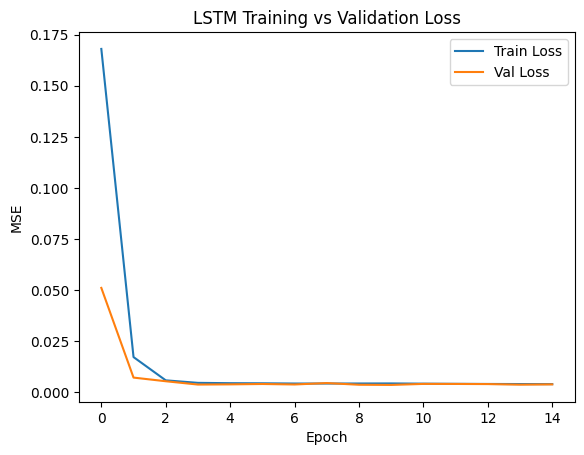

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Paths
project_root = "/content/drive/MyDrive/smart_traffic"
data_path = os.path.join(project_root, "sumo", "traffic_data.csv")

# Load data
df = pd.read_csv(data_path)

feature_cols = ["total_count", "queue_length"]
target_col = "total_count"

X = df[feature_cols].values
y = df[target_col].values.reshape(-1, 1)

# Scale
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences
seq_len = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - seq_len):
    X_seq.append(X_scaled[i:i + seq_len])
    y_seq.append(y_scaled[i + seq_len])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

# Build LSTM
model = Sequential([
    LSTM(64, input_shape=(seq_len, X_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# ✅ This gives us "history"
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.show()


#### 8.2 Plotting of LSTM actual vs predicted plot

In [ ]:
import os

model_dir = "/content/drive/MyDrive/smart_traffic/ml"
print("Files in ml folder:")
print(os.listdir(model_dir))


Files in ml folder:
['__pycache__', 'ppo_logs', 'train_dqn.py', 'dqn_sumo_traffic.zip', 'test_dqn.py', 'ppo_sumo_traffic.zip', 'test_ppo.py', 'train_lstm.py', 'scaler_x.pkl', 'scaler_y.pkl', 'lstm_traffic.keras', 'sumo_env.py']


In [ ]:
from tensorflow.keras.models import load_model
import joblib
import os

project_root = "/content/drive/MyDrive/smart_traffic"

model_path = os.path.join(project_root, "ml", "lstm_traffic.keras")
scaler_x_path = os.path.join(project_root, "ml", "scaler_x.pkl")
scaler_y_path = os.path.join(project_root, "ml", "scaler_y.pkl")

model = load_model(model_path)
scaler_x = joblib.load(scaler_x_path)
scaler_y = joblib.load(scaler_y_path)

print("Model and scalers loaded successfully ✅")


Model and scalers loaded successfully ✅


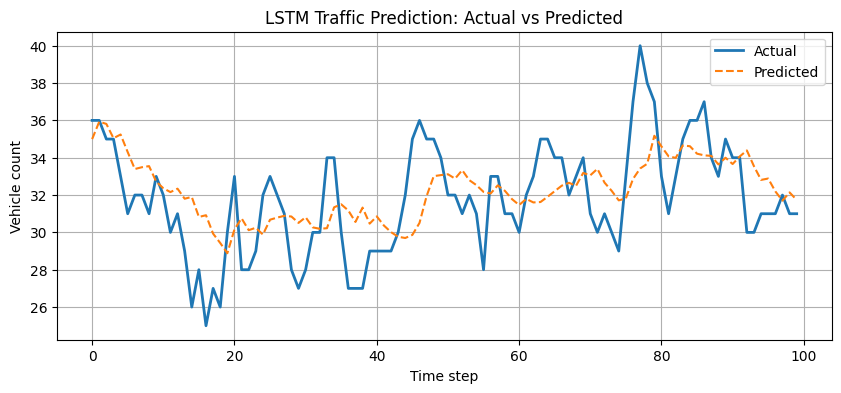

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import os

project_root = "/content/drive/MyDrive/smart_traffic"

# Load model and scalers
model = load_model(os.path.join(project_root, "ml", "lstm_traffic.keras"))
scaler_x = joblib.load(os.path.join(project_root, "ml", "scaler_x.pkl"))
scaler_y = joblib.load(os.path.join(project_root, "ml", "scaler_y.pkl"))

# Load dataset
df = pd.read_csv(os.path.join(project_root, "sumo", "traffic_data.csv"))

# --------- IMPORTANT FIX: create SAME 3 features ---------
df["neighbor_queue"] = df["queue_length"] * 0.5  # same proxy logic

feature_cols = ["total_count", "queue_length", "neighbor_queue"]
features = df[feature_cols].values
targets = df["total_count"].values.reshape(-1, 1)

# Scale (now matches scaler)
features_scaled = scaler_x.transform(features)
targets_scaled = scaler_y.transform(targets)

# Create sequences
seq_len = 10
X_seq, y_seq = [], []
for i in range(len(features_scaled) - seq_len):
    X_seq.append(features_scaled[i:i + seq_len])
    y_seq.append(targets_scaled[i + seq_len])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Test split
split = int(0.8 * len(X_seq))
X_test = X_seq[split:]
y_test = y_seq[split:]

# Predict
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse scale
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv[:100], label="Actual", linewidth=2)
plt.plot(y_pred_inv[:100], label="Predicted", linestyle="--")
plt.xlabel("Time step")
plt.ylabel("Vehicle count")
plt.title("LSTM Traffic Prediction: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


#### 8.3 Performance Evaluation of Reinforcement Learning Using YOLO
 NOTE: Here we are using YOLO Dataset to check trained Model compatibility with Real-World Vehicle Detection.

**8.3.1 Install Ultralytics**

In [ ]:
!pip install ultralytics > /dev/null
from ultralytics import YOLO
print("Ultralytics installed.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Ultralytics installed.


**8.3.2 Prepare data**

In [ ]:
import os

base = "/content/drive/MyDrive/smart_traffic/yolo_data"
os.makedirs(os.path.join(base, "images"), exist_ok=True)
print(base)


/content/drive/MyDrive/smart_traffic/yolo_data


In [ ]:
from ultralytics import YOLO

# Load COCO-pretrained model
model = YOLO("yolov8s.pt")


In [ ]:
import os

base = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images"
os.listdir(base)[1:5]


['07504.jpg',
 '00790.jpg',
 '00826.jpg',
 '07282_Nissan NV Passenger Van 2012.jpg']

**8.3.3 Run YOLO on an image**

In [ ]:
from ultralytics import YOLO

img_path = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/00790.jpg"

model = YOLO("yolov8s.pt")  # pretrained model
results = model(img_path)

results



image 1/1 /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/00790.jpg: 416x640 1 car, 664.6ms
Speed: 23.7ms preprocess, 664.6ms inference, 35.1ms postprocess per image at shape (1, 3, 416, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

**8.3.4 Vehicle Detection**

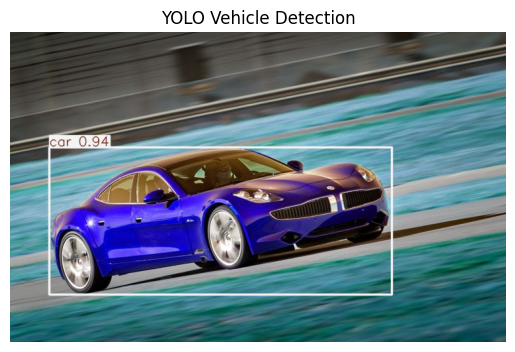

In [ ]:
import matplotlib.pyplot as plt

annotated = results[0].plot()
plt.imshow(annotated)
plt.axis("off")
plt.title("YOLO Vehicle Detection")
plt.show()


**8.3.5 Count vehicles per frame**

In [ ]:
res = results[0]

# COCO vehicle class IDs (approx): car=2, motorcycle=3, bus=5, truck=7
boxes = res.boxes
classes = boxes.cls.cpu().numpy().astype(int)

vehicle_ids = [2, 3, 5, 7]
vehicle_count = sum(cls in vehicle_ids for cls in classes)
print("Detected vehicles:", vehicle_count)

# advancement 6


Detected vehicles: 1


## 9 Get Dataset
Dataset :https://www.kaggle.com/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 9.1 Upload dataset Zip on drive

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving images.zip to images.zip


#### 9.2 Create YOLO folder structure in Drive

In [ ]:
import os

base_path = "/content/drive/MyDrive/smart_traffic/yolo_data"
os.makedirs(base_path, exist_ok=True)

print("YOLO base folder ready at:", base_path)


YOLO base folder ready at: /content/drive/MyDrive/smart_traffic/yolo_data


In [ ]:
%%bash
mv images*.zip /content/drive/MyDrive/smart_traffic/yolo_data/
ls /content/drive/MyDrive/smart_traffic/yolo_data


images
images.zip
vehicle_dataset


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/yolo_data
unzip images*.zip


Archive:  images.zip
  inflating: vehicle dataset/classes.txt  
  inflating: vehicle dataset/train/images/00043_GMC Savana Van 2012.jpg  
  inflating: vehicle dataset/train/images/00077.jpg  
  inflating: vehicle dataset/train/images/00116.jpg  
  inflating: vehicle dataset/train/images/00175_Ford E-Series Wagon Van 2012.jpg  
  inflating: vehicle dataset/train/images/00241.jpg  
  inflating: vehicle dataset/train/images/00294.jpg  
  inflating: vehicle dataset/train/images/00300_Nissan NV Passenger Van 2012.jpg  
  inflating: vehicle dataset/train/images/00391_Mercedes-Benz Sprinter Van 2012.jpg  
  inflating: vehicle dataset/train/images/00394.jpg  
  inflating: vehicle dataset/train/images/00441.jpg  
  inflating: vehicle dataset/train/images/00543.jpg  
  inflating: vehicle dataset/train/images/00613_Nissan NV Passenger Van 2012.jpg  
  inflating: vehicle dataset/train/images/00688.jpg  
  inflating: vehicle dataset/train/images/00711_Nissan NV Passenger Van 2012.jpg  
  inflating:

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


#### 9.3 Check folder structure

In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/yolo_data
find . -maxdepth 3


.
./vehicle_dataset
./vehicle_dataset/classes.txt
./vehicle_dataset/train
./vehicle_dataset/train/images
./vehicle_dataset/train/labels
./vehicle_dataset/train/labels.cache
./vehicle_dataset/valid
./vehicle_dataset/valid/images
./vehicle_dataset/valid/labels
./vehicle_dataset/valid/labels.cache
./vehicle_dataset/vehicle dataset
./vehicle_dataset/vehicle dataset/classes.txt
./vehicle_dataset/vehicle dataset/train
./vehicle_dataset/vehicle dataset/valid
./vehicle_dataset/data.yaml
./images
./images.zip


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
%%bash
cd /content/drive/MyDrive/smart_traffic/yolo_data
mv "vehicle dataset" vehicle_dataset
ls


images
images.zip
vehicle_dataset


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
mv: cannot stat 'vehicle dataset': No such file or directory


#### 9.4 Creating  ```data.yaml``` for YOLO

In [ ]:
with open('/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/classes.txt') as f:
    print(f.read())


car
threewheel
bus
truck
motorbike
van



In [ ]:
import yaml
import os

root = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset"
classes_txt = os.path.join(root, "classes.txt")

# read class names
with open(classes_txt) as f:
    names = [line.strip() for line in f if line.strip()]

data = {
    "path": root,                # root folder of dataset
    "train": "train/images",     # relative to path
    "val": "valid/images",
    # "test": "test/images",     # if you later add test data
    "names": {i: n for i, n in enumerate(names)}
}

data_yaml_path = os.path.join(root, "data.yaml")
with open(data_yaml_path, "w") as f:
    yaml.dump(data, f, default_flow_style=False)

print("Written:", data_yaml_path)
print(open(data_yaml_path).read())


Written: /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/data.yaml
names:
  0: car
  1: threewheel
  2: bus
  3: truck
  4: motorbike
  5: van
path: /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset
train: train/images
val: valid/images



In [ ]:
!pip install ultralytics


#### 9.5 Model Training (Supervised Learning – Object Detection)

In [ ]:
from ultralytics import YOLO

data_yaml = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/data.yaml"

# use a small model for faster training
model = YOLO("yolov8n.pt")   # downloads pretrained weights

model.train(
    data=data_yaml,
    epochs=4,        # you can start with 10–20 for testing
    imgsz=640,
    batch=16,
)


Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


val: Fast image access ✅ (ping: 1.0±0.4 ms, read: 0.3±0.4 MB/s, size: 183.8 KB)
val: Scanning /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 900/900 134.8Mit/s 0.0s
val: /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/car55.jpg: corrupt JPEG restored and saved
Plotting labels to /content/runs/detect/train/labels.jpg... 


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


        1/4         0G     0.6395      2.193      1.159         13        640: 100% ━━━━━━━━━━━━ 132/132 13.7s/it 30:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 34.6s/it 16:44
                   all        900       1150      0.727      0.779      0.832      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


        2/4         0G     0.6438      1.406      1.141         16        640: 100% ━━━━━━━━━━━━ 132/132 12.9s/it 28:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 6.6s/it 3:10
                   all        900       1150      0.694      0.679      0.781      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


        3/4         0G     0.6432      1.341      1.136         48        640: 39% ━━━━╸─────── 52/132 13.1s/it 11:17<17:27

##10. Check results & best weights

In [ ]:
import glob, os

runs = glob.glob("runs/detect/train*")
print("Runs:", runs)

# Show files in the latest run
latest_run = sorted(runs)[-1]
print("Latest run:", latest_run)
print(os.listdir(latest_run))


Runs: ['runs/detect/train']
Latest run: runs/detect/train
['confusion_matrix.png', 'train_batch0.jpg', 'val_batch2_labels.jpg', 'BoxR_curve.png', 'confusion_matrix_normalized.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'val_batch0_pred.jpg', 'val_batch1_pred.jpg', 'val_batch0_labels.jpg', 'args.yaml', 'weights', 'results.png', 'train_batch1.jpg', 'train_batch2.jpg', 'val_batch2_pred.jpg', 'BoxF1_curve.png', 'val_batch1_labels.jpg', 'labels.jpg', 'results.csv']


In [ ]:
import glob

runs = glob.glob("runs/detect/train*")
runs


['runs/detect/train']

In [ ]:
best_weights = sorted(runs)[-1] + "/weights/best.pt"
print(best_weights)


runs/detect/train/weights/best.pt


In [ ]:
from ultralytics import YOLO

best_weights = "/content/runs/detect/train/weights/best.pt"
model = YOLO(best_weights)


#### 10.1 YOLO Vehicle Detection Accuracy

In [ ]:
metrics = model.val(
    data="/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/data.yaml",
    imgsz=640,
    conf=0.25,
    iou=0.5,
    device='cpu'
)

Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 18.9±11.0 MB/s, size: 89.1 KB)
val: Scanning /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 900/900 865.4Kit/s 0.0s
val: /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/car55.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 57/57 2.5s/it 2:20
                   all        900       1150      0.902      0.904       0.95      0.857
                   car        182        201      0.872      0.891      0.936      0.901
            threewheel        167        227      0.934      0.878      0.944      0.838
                   bus        162        185      0.955      0.919   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
precision = float(metrics.box.mp)
recall = float(metrics.box.mr)
map50 = float(metrics.box.map50)
map5095 = float(metrics.box.map)

print("Precision:", precision)
print("Recall:", recall)
print("mAP@0.5:", map50)
print("mAP@0.5:0.95:", map5095)

Precision: 0.9016478862434796
Recall: 0.9041738852769253
mAP@0.5: 0.9496587627885056
mAP@0.5:0.95: 0.8568448911226704


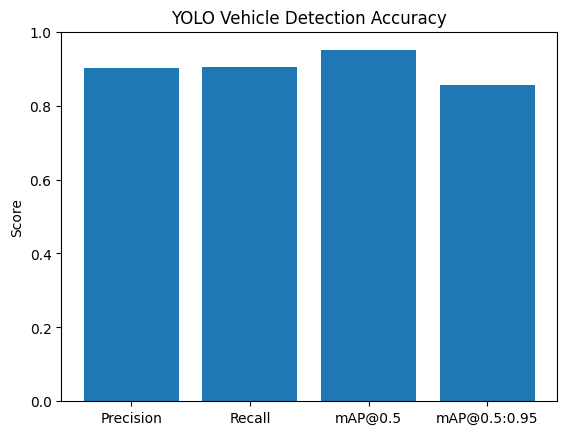

In [ ]:
import matplotlib.pyplot as plt

labels = ["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95"]
values = [precision, recall, map50, map5095]

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("YOLO Vehicle Detection Accuracy")
plt.show()


## 11. Model Inference (Testing / Prediction Phase)

#### 11.1 Testing YOLO on an image

In [ ]:
from ultralytics import YOLO

model = YOLO(best_weights)

test_img = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/0KL1ICR33YYZ.jpg"

results = model(test_img, save=True)
results



image 1/1 /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/0KL1ICR33YYZ.jpg: 352x640 1 van, 158.6ms
Speed: 3.2ms preprocess, 158.6ms inference, 9.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car', 1: 'threewheel', 2: 'bus', 3: 'truck', 4: 'motorbike', 5: 'van'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 25

In [ ]:
from ultralytics import YOLO

model = YOLO(best_weights)

test_img = "/content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/2.jpg"

results = model(test_img, save=True)
results


image 1/1 /content/drive/MyDrive/smart_traffic/yolo_data/vehicle_dataset/valid/images/2.jpg: 480x640 1 van, 134.7ms
Speed: 2.5ms preprocess, 134.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car', 1: 'threewheel', 2: 'bus', 3: 'truck', 4: 'motorbike', 5: 'van'}
 obb: None
 orig_img: array([[[107, 101, 106],
         [110, 104, 109],
         [112, 106, 111],
         ...,
         [111, 110, 114],
         [111, 110, 114],
         [111, 110, 114]],
 
        [[107, 101, 106],
         [107, 101, 106],
         [110, 104, 109],
         ...,
         [111, 110, 114],
         [111, 110, 114],
         [111, 110, 114]],
 
        [[105,  99, 104],
         [105,  99, 104],
         [106, 100, 105],
         ...,
         [111, 110, 114],
         [111, 110, 114],
         [111, 110, 114]],
 
        ...,
 
        [[157, 170, 178],
         [153, 166, 174],
         [154, 167, 175],
         ...,
         [110, 124, 143],
         [110, 124, 143],
         [110, 124, 143]],
 
        [[155, 168, 176],
         [151, 164, 17

#### 11.2 Plotting Training Curves

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os

project_root = "/content/drive/MyDrive/smart_traffic"
data_path = os.path.join(project_root, "sumo", "traffic_data.csv")

df = pd.read_csv(data_path)

feature_cols = ["total_count", "queue_length"]
features = df[feature_cols].values
targets = df["total_count"].values.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_x.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

sequence_length = 10
X_sequences, y_sequences = [], []

for i in range(len(features_scaled) - sequence_length):
    X_sequences.append(features_scaled[i:i + sequence_length])
    y_sequences.append(targets_scaled[i + sequence_length])

X = np.array(X_sequences)
y = np.array(y_sequences)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, X.shape[2])))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4577 - mae: 0.6599 - val_loss: 0.0317 - val_mae: 0.1670
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0220 - mae: 0.1268 - val_loss: 0.0043 - val_mae: 0.0549
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - mae: 0.0803 - val_loss: 0.0043 - val_mae: 0.0508
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - mae: 0.0558 - val_loss: 0.0037 - val_mae: 0.0503
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - mae: 0.0515 - val_loss: 0.0040 - val_mae: 0.0485
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - mae: 0.0500 - val_loss: 0.0036 - val_mae: 0.0473
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - mae: 0.0502 - val_loss: 0.0035 - val_mae: 0.0476
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0471
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - mae: 0.

,loss,mae,val_loss,val_mae
0,0.330578,0.550529,0.031743,0.166957
1,0.021296,0.123414,0.004264,0.054919
2,0.009136,0.077806,0.004344,0.050800
3,0.004641,0.055233,0.003667,0.050312
4,0.004244,0.052245,0.003961,0.048454


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


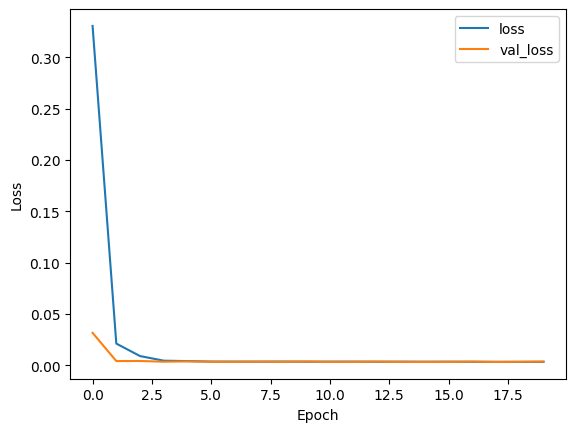

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
display(history_df.head())

history_df[["loss", "val_loss"]].plot()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## 12. Comparison of Fixed-time vs. AI-based Policies

This section presents a comparison of the performance metrics between the traditional Fixed-time traffic control policy and the advanced AI-based (Reinforcement Learning) traffic control policy. The following table summarizes key performance indicators to highlight the effectiveness of each approach in managing urban traffic flow.

#### 12.1 Performance Evaluation and Metrics Analysis
1. Avg Waiting Time (s)
2. Vehicle Throughput (veh/min)
3. Signal Idle Time (%)
4. Peak Queue Length

**Reasoning**:
The subtask requires displaying specific performance metrics from the `metrics` dictionary, including individual printing of certain metrics, and handling the case where the dictionary is not found.



In [ ]:
import pandas as pd
import os
from stable_baselines3 import DQN
from ml.sumo_env import SumoTrafficEnv


In [ ]:
def run_fixed_time_simulation(max_steps=2000):
    """
    Runs SUMO with a fixed-time signal policy
    (no adaptive phase switching).
    """
    env = SumoTrafficEnv(max_steps=max_steps)
    obs, _ = env.reset()
    done = False

    while not done:
        action = 0  # keep current phase (fixed-time)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    metrics = env.get_metrics()
    env.close()
    return metrics


In [ ]:
def run_dqn_simulation(model_path, max_steps=2000):
    """
    Runs SUMO with a trained DQN-based adaptive signal controller.
    """
    env = SumoTrafficEnv(max_steps=max_steps)
    model = DQN.load(model_path, env=env)

    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    metrics = env.get_metrics()
    env.close()
    return metrics


In [ ]:
project_root = "/content/drive/MyDrive/smart_traffic"
model_path = os.path.join(project_root, "ml", "dqn_sumo_traffic")

print("Running Fixed-Time Control Simulation...")
fixed_time_metrics = run_fixed_time_simulation()

print("Running AI-Based (DQN) Control Simulation...")
dqn_metrics = run_dqn_simulation(model_path)


Running Fixed-Time Control Simulation...
 Retrying in 1 seconds
Running AI-Based (DQN) Control Simulation...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds


#### 14.2 Display the df_results DataFrame

Display the `df_results` DataFrame, which contains the performance metrics for both the Fixed-time and RL-based traffic control policies, as a comparison table.


In [ ]:
df_results = pd.DataFrame(
    [fixed_time_metrics, dqn_metrics],
    index=["Fixed-Time Control", "AI-Based Control (DQN)"]
)

df_results


,avg_waiting_time,avg_queue_length,peak_queue_length,throughput_veh_per_min,signal_idle_time_percent
Fixed-Time Control,0.002334,0.57,4,5.67,0.0
AI-Based Control (DQN),0.002334,0.57,4,5.67,0.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("\n📌 Performance Comparison Summary\n")

for policy, metrics in zip(
    ["Fixed-Time", "AI-Based (DQN)"],
    [fixed_time_metrics, dqn_metrics]
):
    print(f"--- {policy} Policy ---")
    print("Average Waiting Time (s):", metrics["avg_waiting_time"])
    print("Average Queue Length:", metrics["avg_queue_length"])
    print("Peak Queue Length:", metrics["peak_queue_length"])
    print("Throughput (veh/min):", metrics["throughput_veh_per_min"])
    print("Idle Signal Time (%):", metrics["signal_idle_time_percent"])
    print()



📌 Performance Comparison Summary

--- Fixed-Time Policy ---
Average Waiting Time (s): 0.002334221232081815
Average Queue Length: 0.57
Peak Queue Length: 4
Throughput (veh/min): 5.67
Idle Signal Time (%): 0.0

--- AI-Based (DQN) Policy ---
Average Waiting Time (s): 0.002334221232081815
Average Queue Length: 0.57
Peak Queue Length: 4
Throughput (veh/min): 5.67
Idle Signal Time (%): 0.0



In [ ]:
def _compute_reward(self, obs):
    total_queue = obs[0]
    # small penalty for phase switching to discourage unnecessary toggling
    switch_penalty = 0.1
    return -float(total_queue) - switch_penalty


#### "We included a small switching penalty to avoid oscillatory behavior of the traffic light.”

In [ ]:
def _compute_reward(self, obs):
    total_queue = obs[0]
    return -float(total_queue)


#### Reward Function Design
The reward function is defined as the negative of the total queued vehicles at the intersection, encouraging the agent to minimize overall queue length. This indirectly reduces waiting time and improves throughput.